In [1]:
import os
import requests
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import optax
from jax import value_and_grad
import pickle
import pandas as pd

from helper_funcs import generate, masked_fill, loss_fn, get_vector_batch, encode, decode
from tqdm import tqdm
import matplotlib.pyplot as plt
print(jax.devices())

[CudaDevice(id=0)]


W1212 15:41:07.371046   26971 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1212 15:41:07.374414   26885 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


## Data Preparation

In [2]:
with open('vocab.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

vocab_size = len(loaded_data['vocab'])
print(vocab_size)

X = pd.read_parquet("X.parquet")
X

13359


,Power demand,temp,dwpt,rhum,wdir,wspd,pres,cluster,next_cluster,vector_id
0,1999.076667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
1,1952.006667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
2,1882.133333,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
3,1822.866667,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
4,1779.133333,8.0,6.9,93.0,0.0,0.0,1017.0,72,72,0
...,...,...,...,...,...,...,...,...,...,...
110663,3411.043333,22.0,3.1,29.0,320.0,13.0,1016.8,59,117,12808
110664,3506.576667,21.0,3.2,31.0,290.0,9.4,1017.0,117,117,0
110665,3504.670000,21.0,3.2,31.0,290.0,9.4,1017.0,117,117,0
110666,3478.290000,21.0,3.2,31.0,290.0,9.4,1017.0,117,117,0


In [3]:
from attention_model import *

with open('model.pickle', 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)

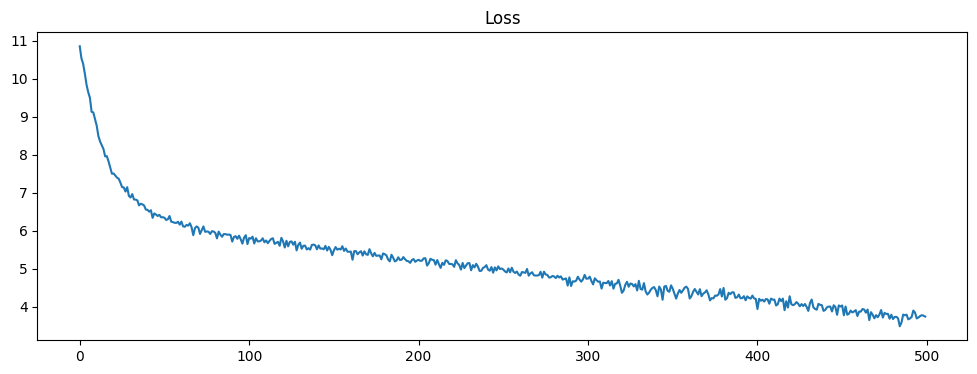

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Time Series Generation Post-Training

In [5]:
rng_key = jax.random.PRNGKey(128)

In [15]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens+1:t+max_new_tokens+max_new_tokens+1].reset_index()
x = [encode(X_test)]
index_seq = jnp.array(x)

print(index_seq.shape)
#print(index_seq)

(1, 480)


In [16]:
rng_key, subkey = jax.random.split(rng_key)
generated_indices = generate(variables, model.apply, index_seq, rng_key, vocab_size, 1, block_size, max_new_tokens)
generated_indices = list(np.array(generated_indices[0]))
Y = decode(generated_indices, X)

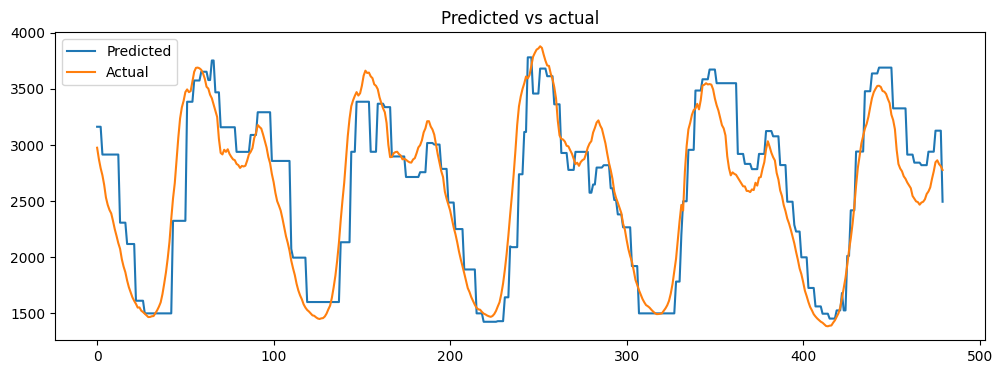

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(Y.index, Y['Power demand'], label="Predicted")
plt.plot(Y_test.index, Y_test['Power demand'], label="Actual")
plt.title('Predicted vs actual')
plt.legend()
plt.show()